<h1>Regression Analysis</h1>

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import pydotplus
from sklearn import tree
import collections
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV

In [63]:
dataset = pd.read_csv('network_backup_dataset.csv')
dataset.head()

Week # Day of Week  Backup Start Time - Hour of Day Work-Flow-ID File Name  \
0       1      Monday                                1  work_flow_0    File_0   
1       1      Monday                                1  work_flow_2   File_12   
2       1      Monday                                1  work_flow_2   File_13   
3       1      Monday                                1  work_flow_2   File_14   
4       1      Monday                                1  work_flow_2   File_16   

   Size of Backup (GB)  Backup Time (hour)  
0                  0.0                   0  
1                  0.0                   0  
2                  0.0                   0  
3                  0.0                   0  
4                  0.0                   0

<h2>Question 1 - a, b</h2>

In [64]:
def encode_day_names(days):
    day_to_num = dict(zip(list(calendar.day_name), range(1, 8)))
    return [day_to_num[day] for day in days]

In [65]:
def plot_dataset(df):
    fig, ax = plt.subplots()
    labels = []
    for wid, wgrp in df.groupby('Work-Flow-ID'):
        ax = wgrp.groupby('Day #').sum().plot(
                ax = ax,
                kind = 'line',
                y = 'Size of Backup (GB)',
            marker='.',
     markerfacecolor='#42A5F5', markersize=3
            )
        labels.append(wid)

        lines, _ = ax.get_legend_handles_labels()

        plt.xlabel('Day number')
        plt.ylabel('Backup size (GB)')

        ax.legend(lines, labels, bbox_to_anchor=(1, 1))
        ax.set_title('Backup size variation')
    plt.show()

In [66]:
dataset['Day #'] = (dataset['Week #'] - 1) * 7 + encode_day_names(dataset['Day of Week'])

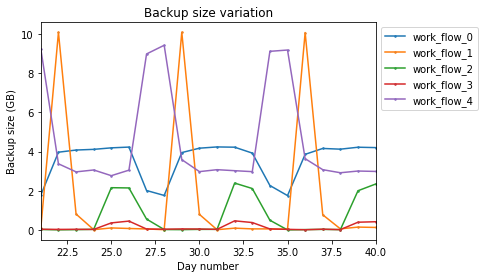

In [67]:
twenty = dataset.loc[dataset['Day #'] >= 21]
twenty = twenty.loc[twenty['Day #'] <= 40]
plot_dataset(twenty)

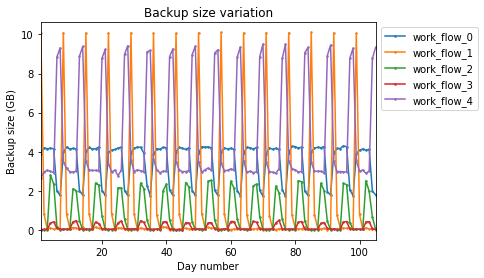

In [68]:
first105 = dataset.loc[dataset['Day #'] <= 105]
plot_dataset(first105)

<h2>Question 2 - a</h2>

In [69]:
df = dataset.replace({'Day of Week': {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5,
                                  'Saturday': 6, 'Sunday': 7},
                  'Work-Flow-ID': {'work_flow_0': 0, 'work_flow_1': 1, 'work_flow_2': 2, 'work_flow_3': 3,
                                   'work_flow_4': 4},
                  'File Name': {'File_0': 0, 'File_1': 1, 'File_2': 2, 'File_3': 3, 'File_4': 4, 'File_5': 5,
                                'File_6': 6, 'File_7': 7, 'File_8': 8, 'File_9': 9, 'File_10': 10, 'File_11': 11,
                                'File_12': 12, 'File_13': 13, 'File_14': 14, 'File_15': 15, 'File_16': 16,
                                'File_17': 17, 'File_18': 18, 'File_19': 19, 'File_20': 20, 'File_21': 21,
                                'File_22': 22,
                                'File_23': 23, 'File_24': 24, 'File_25': 25, 'File_26': 26, 'File_27': 27,
                                'File_28': 28, 'File_29': 29, }})

In [70]:
df.head()

Week #  Day of Week  Backup Start Time - Hour of Day  Work-Flow-ID  \
0       1            1                                1             0   
1       1            1                                1             2   
2       1            1                                1             2   
3       1            1                                1             2   
4       1            1                                1             2   

   File Name  Size of Backup (GB)  Backup Time (hour)  Day #  
0          0                  0.0                   0      1  
1         12                  0.0                   0      1  
2         13                  0.0                   0      1  
3         14                  0.0                   0      1  
4         16                  0.0                   0      1

In [71]:
X = df[
    ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']].values
y = df['Size of Backup (GB)'].values

### Part i

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print ("Coefficients:", linreg.coef_)
print ("Intercept:", linreg.intercept_)
y_predict = linreg.predict(X_test)
print("RMSE without cross validation:", np.sqrt(mean_squared_error(y_test, y_predict)))

Coefficients: [ -4.46137250e-05  -2.40527826e-03   1.38306408e-03  -4.14520552e-04
   4.85929375e-04]
Intercept: 0.049413880522
RMSE without cross validation: 0.106503866998


In [73]:
def perform_10fold(X,y,regressor):
    kf = KFold(n_splits=10,shuffle=True, random_state=0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        #print("Fold : ",i)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train)
        train_preds = regressor.predict(X_train)
        test_preds = regressor.predict(X_test)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        #print("Training RMSE : ",np.sqrt(mean_squared_error(y_train,train_preds)))
        #print("Test RMSE : ",np.sqrt(test_error))
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

In [74]:
def plot_graph(x,y,xlabel,ylabel,title):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x, y, color='#42A5F5', lw=1, label=y,s=.1)
    #plt.plot([y.min(), y.max()], [0,0], 'k--', lw=4)
    plt.show()

In [75]:
def plot_graph_time(y1,y2,y1label,y2label,ylabel,title):
    plt.title(title)
    plt.scatter(np.arange(y1.shape[0]), y1, color='#42A5F5', label=y1label,s=.1)
    plt.scatter(np.arange(y1.shape[0]), y2, color='#FF6E40', label=y2label,s=.1)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

In [76]:
regressor = LinearRegression()
avg_tr,avg_ts,bestModel = perform_10fold(X,y,regressor)
print("------------------------------")
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)

------------------------------
Average Training RMSE :  0.103587856885
Average Test RMSE :  0.103627896737


In [77]:
regressor = LinearRegression()
regressor.fit(X,y)
predicted = regressor.predict(X)

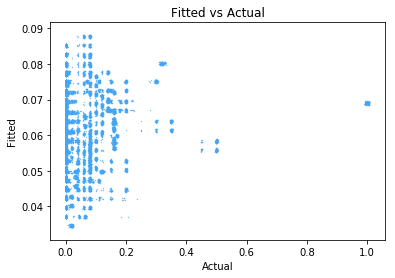

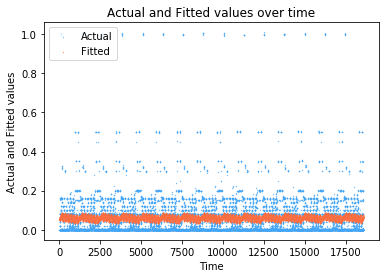

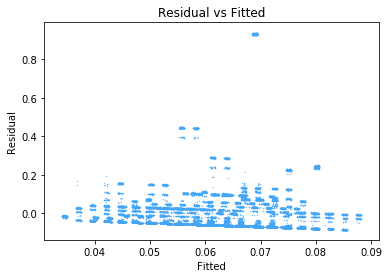

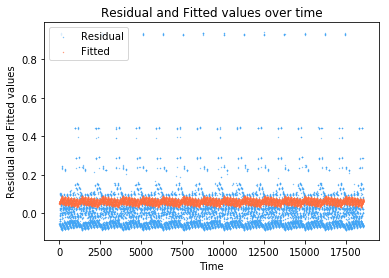

In [78]:
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

### Part ii

In [79]:
X = df[
    ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']].values
y = df['Size of Backup (GB)'].values

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state = 0)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
linreg = LinearRegression()
linreg.fit(X_train_std, y_train)
print ("Coefficients:", linreg.coef_)
print ("Intercept:", linreg.intercept_)
y_predict = linreg.predict(X_test_std)
print("RMSE without cross validation:", np.sqrt(mean_squared_error(y_test, y_predict)))

Coefficients: [-0.00019274 -0.00479403  0.00944936 -0.00058665  0.00420832]
Intercept: 0.0607646798087
RMSE without cross validation: 0.106503866998


/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [81]:
def perform_10fold_std(X,y,regressor):
    kf = KFold(n_splits=10, shuffle=True, random_state = 0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        print("Fold : ",i)
        scaler = StandardScaler()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        regressor.fit(X_train_std,y_train)
        train_preds = regressor.predict(X_train_std)
        test_preds = regressor.predict(X_test_std)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        print("Training RMSE : ",np.sqrt(mean_squared_error(y_train,train_preds)))
        print("Test RMSE : ",np.sqrt(test_error))
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

In [82]:
regressor = LinearRegression()
avg_tr,avg_ts,bestModel = perform_10fold_std(X,y,regressor)
print("------------------------------")
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Fold :  1
Training RMSE :  0.103265021252
Test RMSE :  0.106503866998
Fold :  2
Training RMSE :  0.103428926322
Test RMSE :  0.105029409306
Fold :  3
Training RMSE :  0.101891490799
Test RMSE :  0.117793845398
Fold :  4
Training RMSE :  0.104325747394
Test RMSE :  0.0967244993663
Fold :  5
Training RMSE :  0.104118712604
Test RMSE :  0.0987136373113
Fold :  6
Training RMSE :  0.104606731957
Test RMSE :  0.0939770759809
Fold :  7
Training RMSE :  0.103710941139
Test RMSE :  0.102543127434
Fold :  8
Training RMSE :  0.102680720217
Test RMSE :  0.111465416023
Fold :  9
Training RMSE :  0.103622312889
Test RMSE :  0.103306632317
Fold :  10
Training RMSE :  0.104198598987
Test RMSE :  0.0979498611003
------------------------------
Average Training RMSE :  0.103587856885
Average Test RMSE :  0.103627896737


In [83]:
X2 = scaler.fit_transform(X)
regressor.fit(X2,y)
predicted = regressor.predict(X2)

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


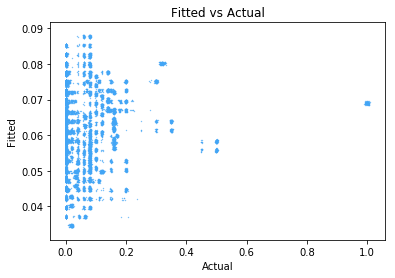

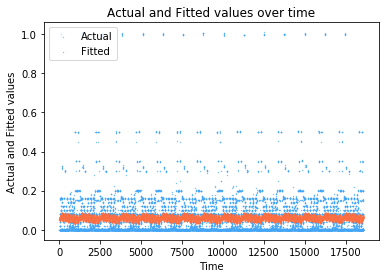

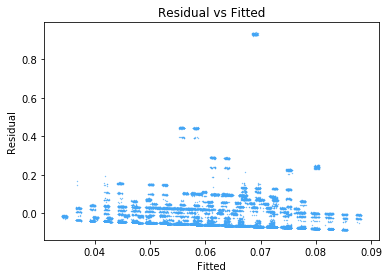

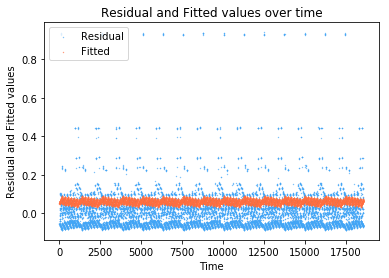

In [84]:
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

### Part iii

In [85]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,mutual_info_regression

In [86]:
X = df[
    ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']].values
y = df['Size of Backup (GB)'].values

In [87]:
selectbest = SelectKBest(f_regression,k=3)
X_f = selectbest.fit_transform(X, y)
selectbest.scores_

array([  8.45006257e-03,   3.88163798e+01,   1.50740934e+02,
         2.61386654e+01,   2.53200943e+01])

#### Best features from f_regression = Day of the week, Backup time - hour of day, workflow id

In [88]:
selectbest2 = SelectKBest(mutual_info_regression,k=3)
X_mi = selectbest2.fit_transform(X, y)
selectbest2.scores_

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


array([ 0.        ,  0.2191824 ,  0.23559804,  0.28081528,  0.42935735])

#### Best features from mutual_info_regression = Backup time - hour of day, workflow id, file name

In [89]:
regressor = LinearRegression()
avg_tr,avg_ts,bestModel_f = perform_10fold(X_f,y,regressor)
print("------------------------------")
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)

------------------------------
Average Training RMSE :  0.103588792478
Average Test RMSE :  0.103611218666


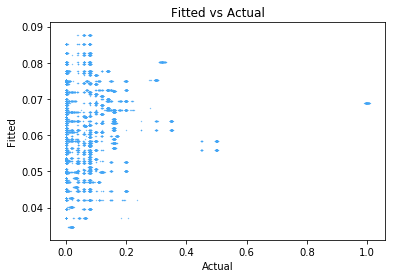

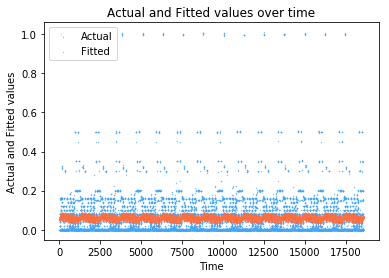

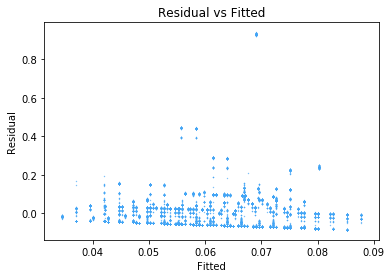

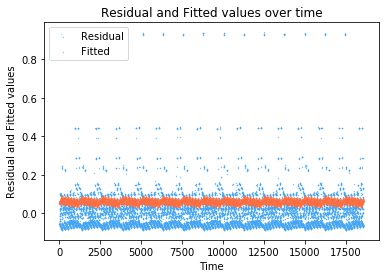

In [90]:
regressor.fit(X_f,y)
predicted = regressor.predict(X_f)
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

In [91]:
regressor = LinearRegression()
avg_tr,avg_ts,bestModel_mi = perform_10fold(X_mi,y,regressor)
print("------------------------------")
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)

------------------------------
Average Training RMSE :  0.103697228859
Average Test RMSE :  0.103720626763


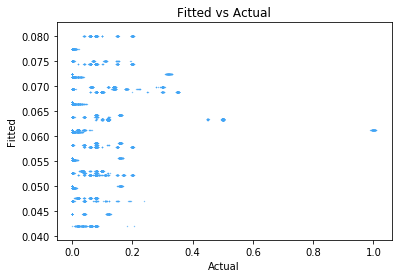

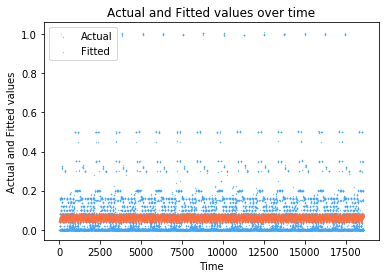

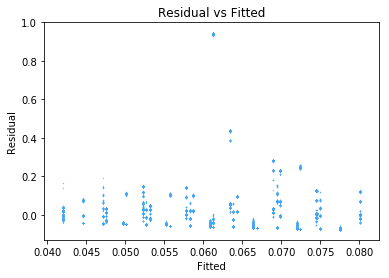

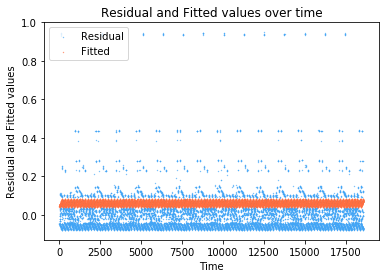

In [92]:
regressor.fit(X_mi,y)
predicted = regressor.predict(X_mi)
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

### Part iv

In [93]:
mask = []
for i in range(0,6):
    for j in itertools.combinations([0,1,2,3,4],i):
        mask_temp = [False,False,False,False,False]
        for index in j:
            mask_temp[index] = True
        mask.append(mask_temp)

Encoding :  [False, False, False, False, False]
Average Training RMSE :  0.103587856885
Average Test RMSE :  0.103627896737


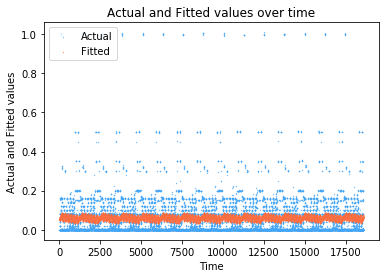

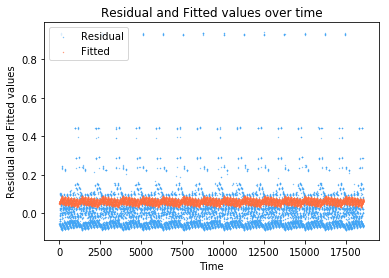

In [94]:
#Without one hot encoding
tr_l = []
ts_l = []
print("Encoding : ",mask[0])
regressor = LinearRegression()
avg_tr,avg_ts,bestModel = perform_10fold(X,y,regressor)
tr_l.append(avg_tr)
ts_l.append(avg_ts)
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)
predicted = bestModel.predict(X)
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")
min_ts_e = avg_ts
bestModel_all = bestModel
best_mask = mask[0]
comb_num = 0

##############################
Encoding :  [True, False, False, False, False]
Average Training RMSE :  0.103582694803
Average Test RMSE :  0.103720392945


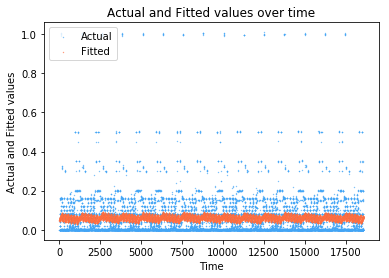

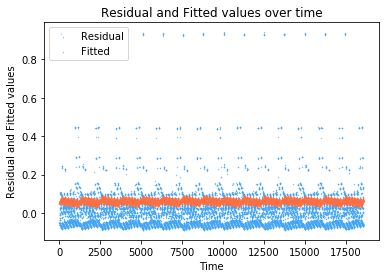

##############################
Encoding :  [False, True, False, False, False]
Average Training RMSE :  0.102151365372
Average Test RMSE :  0.102219981311


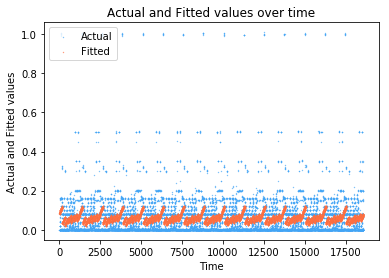

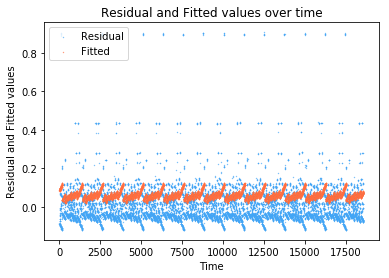

##############################
Encoding :  [False, False, True, False, False]
Average Training RMSE :  0.102362582
Average Test RMSE :  0.102454594314


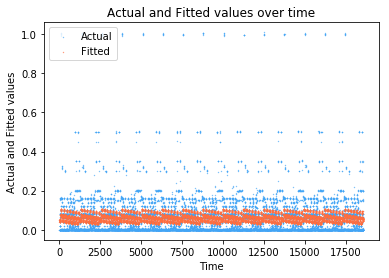

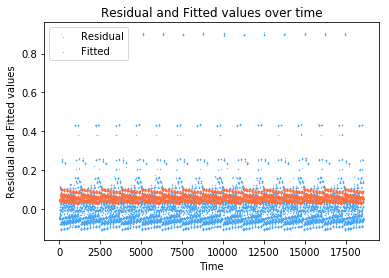

##############################
Encoding :  [False, False, False, True, False]
Average Training RMSE :  0.0913448742395
Average Test RMSE :  0.0913876247056


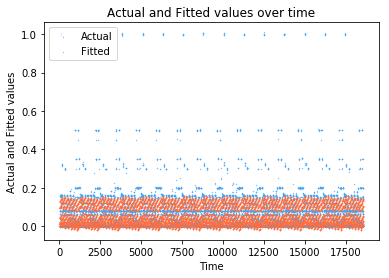

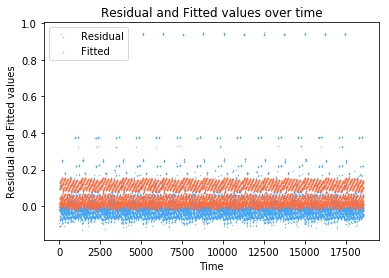

##############################
Encoding :  [False, False, False, False, True]
Average Training RMSE :  0.0913359452862
Average Test RMSE :  0.0915388299517


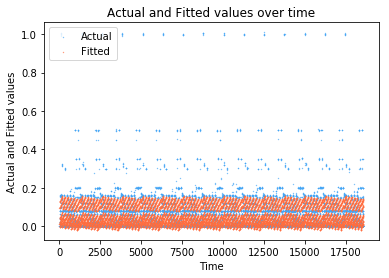

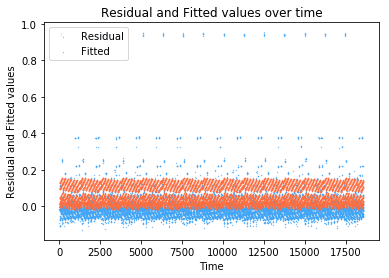

##############################
Encoding :  [True, True, False, False, False]
Average Training RMSE :  0.102146464374
Average Test RMSE :  0.102309283172


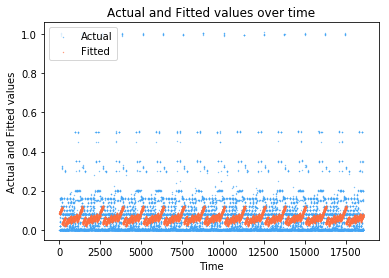

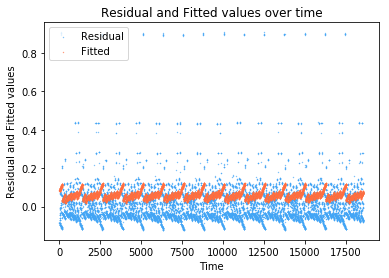

##############################
Encoding :  [True, False, True, False, False]
Average Training RMSE :  0.102356556194
Average Test RMSE :  0.102540081691


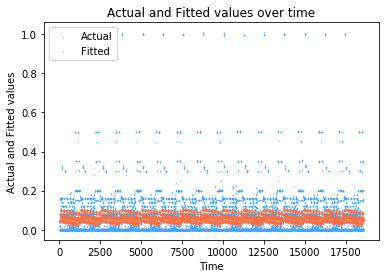

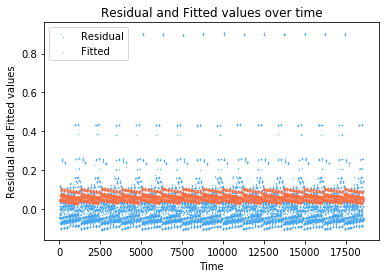

##############################
Encoding :  [True, False, False, True, False]
Average Training RMSE :  0.091339891868
Average Test RMSE :  0.0914653225294


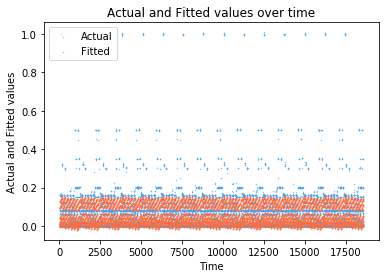

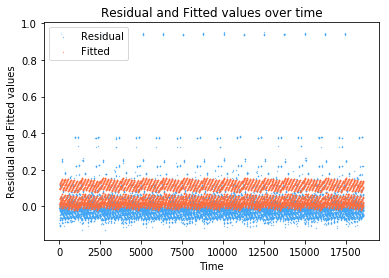

##############################
Encoding :  [True, False, False, False, True]
Average Training RMSE :  0.0913305641747
Average Test RMSE :  0.0916130371878


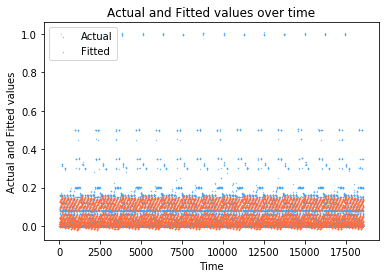

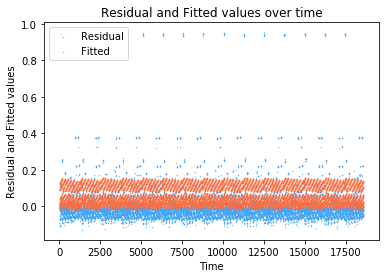

##############################
Encoding :  [False, True, True, False, False]
Average Training RMSE :  0.100906053113
Average Test RMSE :  0.101020190683


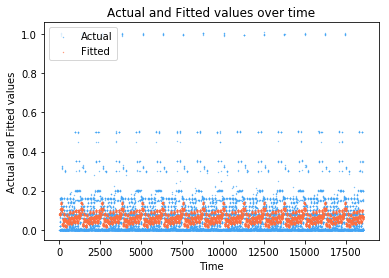

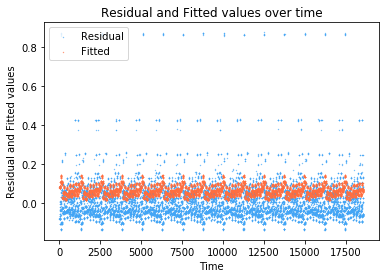

##############################
Encoding :  [False, True, False, True, False]
Average Training RMSE :  0.0897611150021
Average Test RMSE :  0.0898246557368


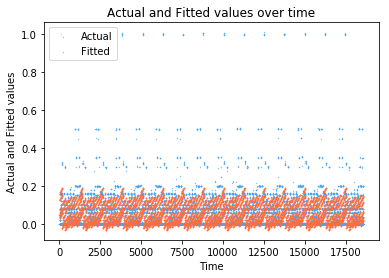

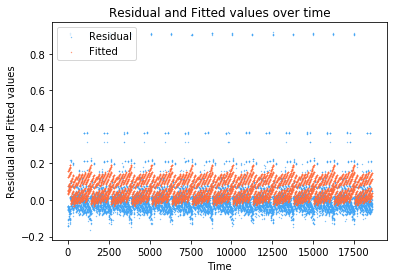

##############################
Encoding :  [False, True, False, False, True]
Average Training RMSE :  0.0897523017686
Average Test RMSE :  0.0899654588358


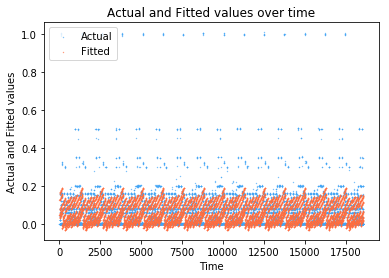

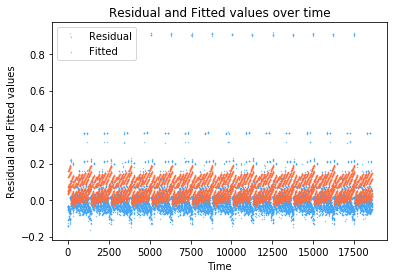

##############################
Encoding :  [False, False, True, True, False]
Average Training RMSE :  0.0899555883518
Average Test RMSE :  0.0900366434602


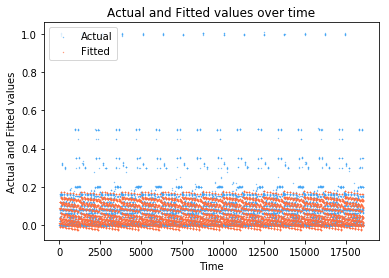

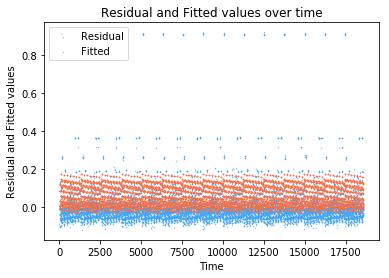

##############################
Encoding :  [False, False, True, False, True]
Average Training RMSE :  0.0899472516438
Average Test RMSE :  0.0902001711434


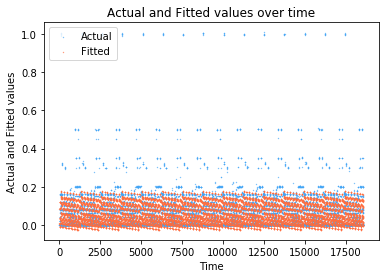

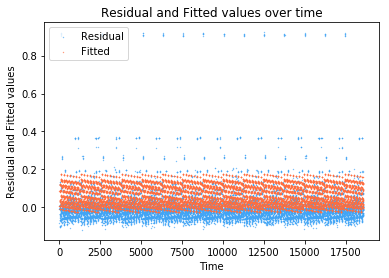

##############################
Encoding :  [False, False, False, True, True]
Average Training RMSE :  0.091340419237
Average Test RMSE :  0.091540668254


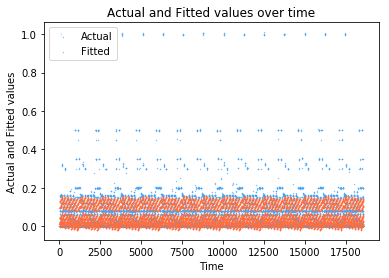

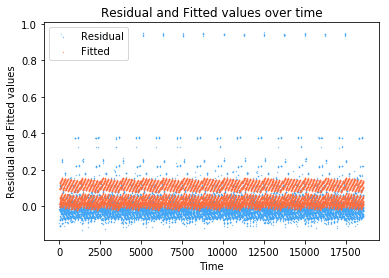

##############################
Encoding :  [True, True, True, False, False]
Average Training RMSE :  0.100900943028
Average Test RMSE :  0.10110090435


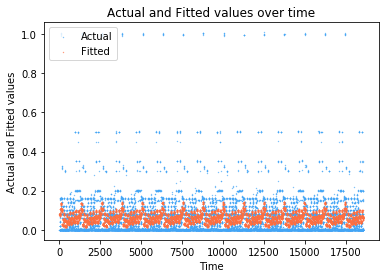

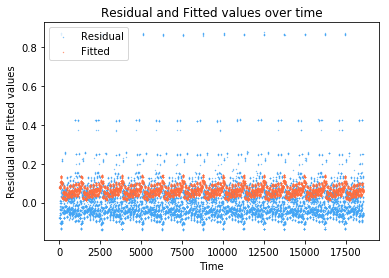

##############################
Encoding :  [True, True, False, True, False]
Average Training RMSE :  0.0897586928766
Average Test RMSE :  0.0899187921991


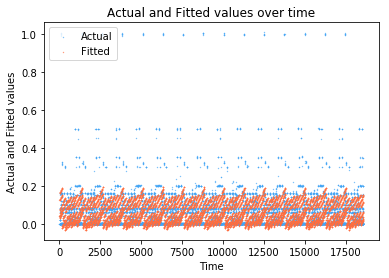

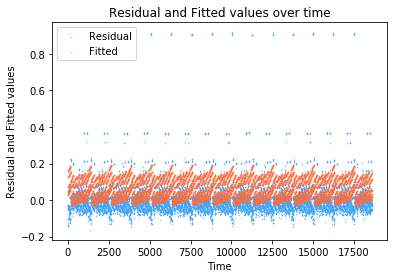

##############################
Encoding :  [True, True, False, False, True]
Average Training RMSE :  0.0897476188212
Average Test RMSE :  0.0900510303835


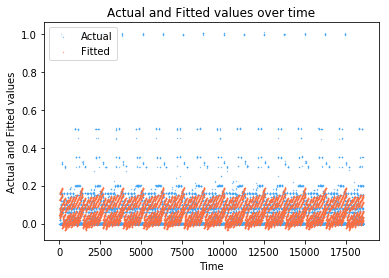

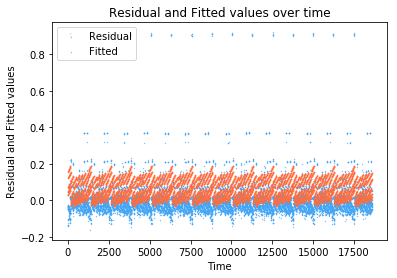

##############################
Encoding :  [True, False, True, True, False]
Average Training RMSE :  0.0899513794303
Average Test RMSE :  0.0901054080674


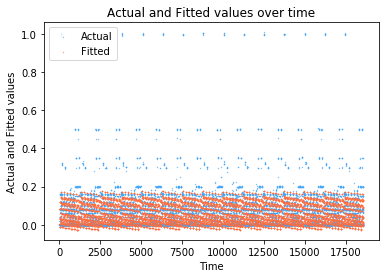

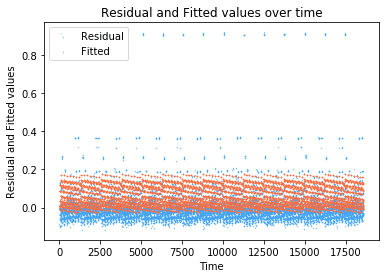

##############################
Encoding :  [True, False, True, False, True]
Average Training RMSE :  0.0899679431143
Average Test RMSE :  0.0902812089422


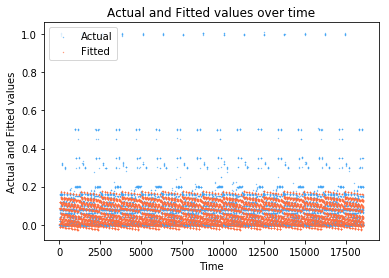

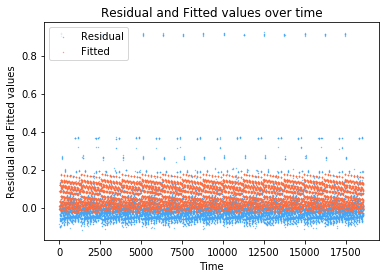

##############################
Encoding :  [True, False, False, True, True]
Average Training RMSE :  0.0913351778858
Average Test RMSE :  0.0916081653326


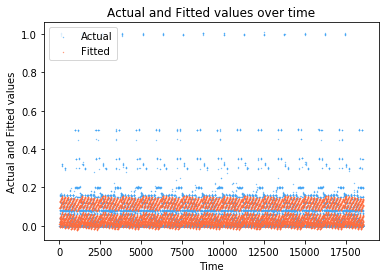

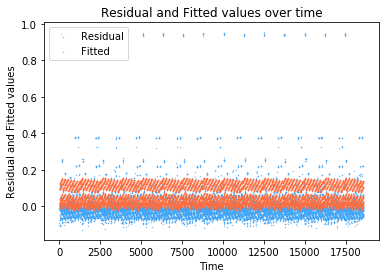

##############################
Encoding :  [False, True, True, True, False]
Average Training RMSE :  0.0883442861787
Average Test RMSE :  0.0884437842078


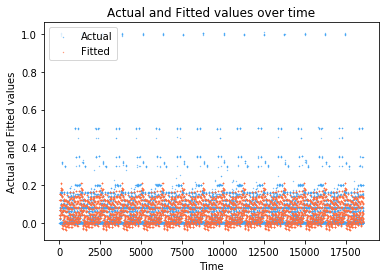

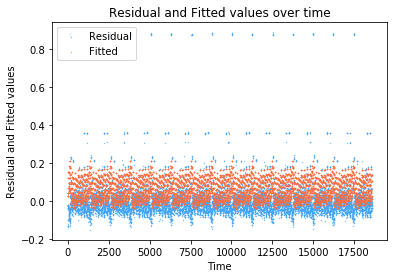

##############################
Encoding :  [False, True, True, False, True]
Average Training RMSE :  0.0885056630476
Average Test RMSE :  0.0887858949512


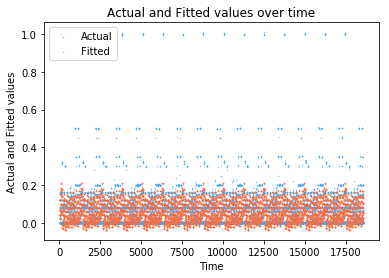

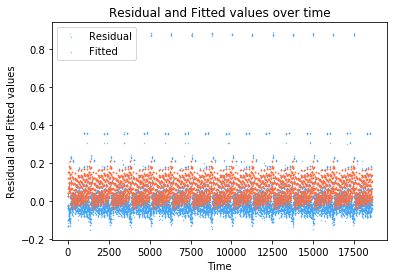

##############################
Encoding :  [False, True, False, True, True]
Average Training RMSE :  0.0897870110187
Average Test RMSE :  0.0900269806253


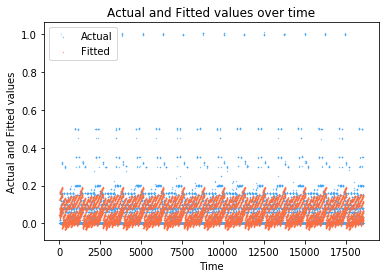

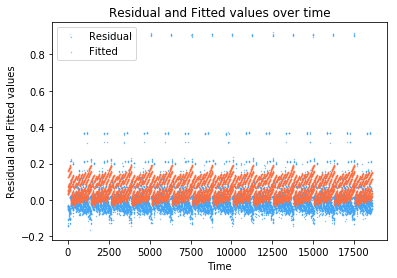

##############################
Encoding :  [False, False, True, True, True]
Average Training RMSE :  0.0899730220284
Average Test RMSE :  0.0901786948626


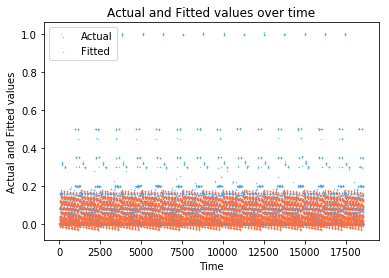

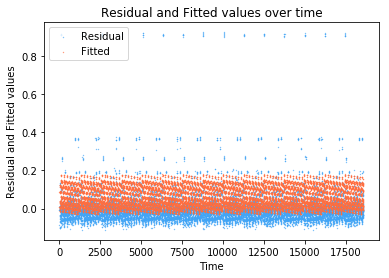

##############################
Encoding :  [True, True, True, True, False]
Average Training RMSE :  0.088442211613
Average Test RMSE :  0.0885847836358


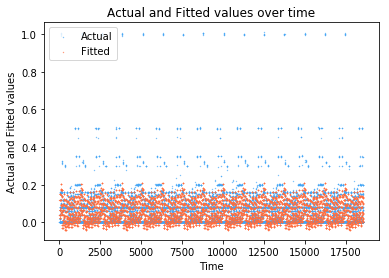

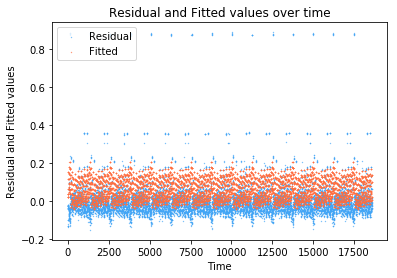

##############################
Encoding :  [True, True, True, False, True]
Average Training RMSE :  0.0883349941039
Average Test RMSE :  0.0886634369554


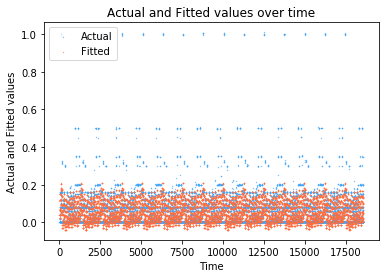

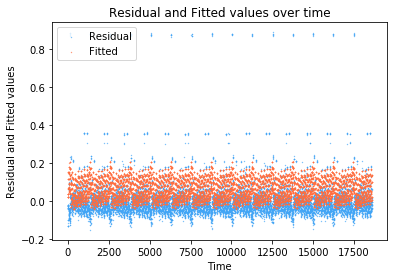

##############################
Encoding :  [True, True, False, True, True]
Average Training RMSE :  0.0897499726105
Average Test RMSE :  0.0900613723211


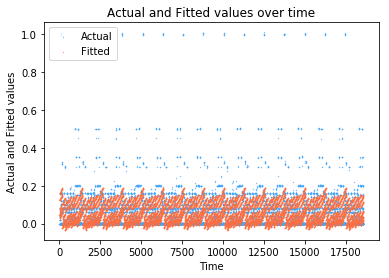

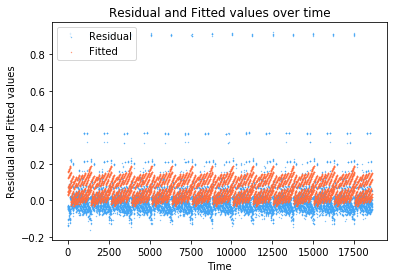

##############################
Encoding :  [True, False, True, True, True]
Average Training RMSE :  0.0899590938804
Average Test RMSE :  0.0902700966677


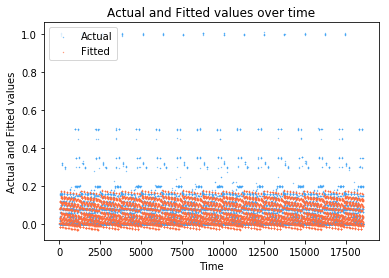

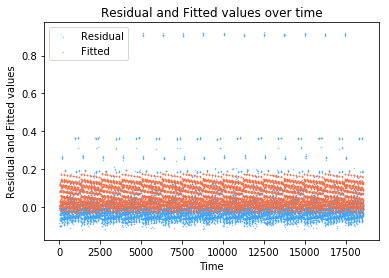

##############################
Encoding :  [False, True, True, True, True]
Average Training RMSE :  0.0883379759816
Average Test RMSE :  0.0885926646416


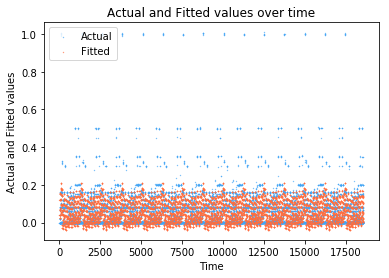

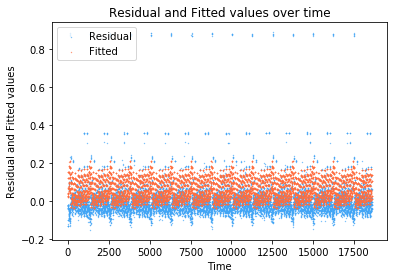

##############################
Encoding :  [True, True, True, True, True]
Average Training RMSE :  0.0883521278874
Average Test RMSE :  0.0886614787309


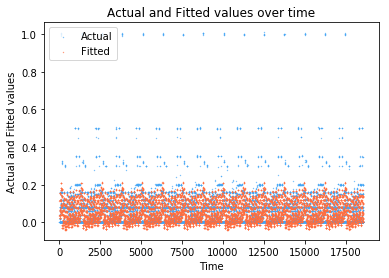

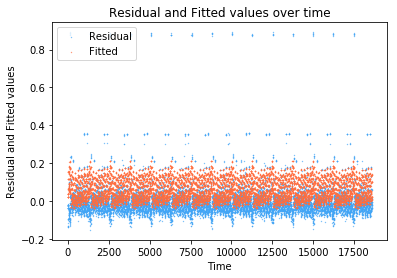

--------------------------------
Best Combination :  [False, True, True, True, False]
Combination Number :  22
Training RMSE :  0.0883442861787
Test RMSE :  0.0884437842078
Coefficients :  [  1.45186675e+10   1.45186675e+10   1.45186675e+10   1.45186675e+10
   1.45186675e+10   1.45186675e+10   1.45186675e+10   2.37452697e+10
   2.37452697e+10   2.37452697e+10   2.37452697e+10   2.37452697e+10
   2.37452697e+10   2.21443274e+08   2.21443274e+08   2.21443274e+08
   2.21443274e+08   2.21443274e+08   3.14712524e-05   3.81469727e-05]
Intercept :  -38485380509.9


In [95]:
for i in range(1,32):
    print("##############################")
    print("Encoding : ",mask[i])
    encoder = OneHotEncoder(categorical_features = mask[i])
    X_encoded = encoder.fit_transform(X).toarray()
    regressor = LinearRegression()
    avg_tr,avg_ts,bestModel = perform_10fold(X_encoded,y,regressor)
    tr_l.append(avg_tr)
    ts_l.append(avg_ts)
    print("Average Training RMSE : ",avg_tr)
    print("Average Test RMSE : ",avg_ts)
    predicted = bestModel.predict(X_encoded)
    #plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
    plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
    #plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
    plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")
    if(avg_ts<min_ts_e):
            min_ts_e = avg_ts
            min_tr_e = avg_tr
            bestModel_all = bestModel
            best_mask = mask[i]
            comb_num = i
print("--------------------------------")
print("Best Combination : ",best_mask)
print("Combination Number : ",comb_num)
print("Training RMSE : ",min_tr_e)
print("Test RMSE : ",min_ts_e)
print("Coefficients : ",bestModel_all.coef_)
print("Intercept : ",bestModel_all.intercept_)

In [96]:
for i in range(0,32) :
    if ts_l[i] > 1:
        ts_l[i] = 1

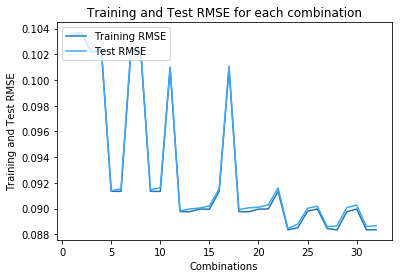

In [97]:
plt.title("Training and Test RMSE for each combination")
plt.plot(range(1,33), tr_l, label="Training RMSE")
plt.plot(range(1,33), ts_l, color='#42A5F5', label='Test RMSE')
plt.legend(loc = 'upper left')
plt.xlabel("Combinations")
plt.ylabel("Training and Test RMSE")
plt.show()

### Part v

In [98]:
new_ridge = Ridge()
new_lasso = Lasso()
new_elasticnet = ElasticNet()

In [99]:
def partv(regressor,parameters):
    best_score = 10
    for i in range(1,32):
        print("##############################")
        print("Encoding : ",mask[i])
        encoder = OneHotEncoder(categorical_features = mask[i])
        X_encoded = encoder.fit_transform(X).toarray()
        clf = GridSearchCV(regressor, parameters, cv=10,scoring = 'neg_mean_squared_error')
        clf.fit(X_encoded,y)
        score = np.sqrt(-1 * clf.best_score_)
        print("Best Parameter : ",clf.best_params_)
        print("RMSE : ", score)
        if score < best_score:
            best_score = score
            best_param = clf.best_params_
            best_estimator = clf.best_estimator_
            best_mask = mask[i]
    print("---------------------------")
    print("Best Combination : ",best_mask)
    print("Parameter : ",best_param)
    print("Test RMSE : ",best_score)
    print("Coefficients : ",best_estimator.coef_)
    print("Intercept : ",best_estimator.intercept_)

In [100]:
parameters = {'alpha':[0.0001,0.001,0.1,1,10,100,1000,10000]}
partv(new_ridge,parameters)

##############################
Encoding :  [True, False, False, False, False]
Best Parameter :  {'alpha': 10000}
RMSE :  0.103673664218
##############################
Encoding :  [False, True, False, False, False]
Best Parameter :  {'alpha': 10}
RMSE :  0.102231852837
##############################
Encoding :  [False, False, True, False, False]
Best Parameter :  {'alpha': 10}
RMSE :  0.102465499369
##############################
Encoding :  [False, False, False, True, False]
Best Parameter :  {'alpha': 10}
RMSE :  0.0914970533256
##############################
Encoding :  [False, False, False, False, True]
Best Parameter :  {'alpha': 1}
RMSE :  0.0914984086895
##############################
Encoding :  [True, True, False, False, False]
Best Parameter :  {'alpha': 100}
RMSE :  0.102242640467
##############################
Encoding :  [True, False, True, False, False]
Best Parameter :  {'alpha': 100}
RMSE :  0.102551175986
##############################
Encoding :  [True, False, False, T

In [101]:
parameters = {'alpha':[0.0001,0.001,0.1,1,10,100,1000,10000]}
partv(new_lasso,parameters)

##############################
Encoding :  [True, False, False, False, False]
Best Parameter :  {'alpha': 0.001}
RMSE :  0.103671129332
##############################
Encoding :  [False, True, False, False, False]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.102233153569
##############################
Encoding :  [False, False, True, False, False]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.102467016538
##############################
Encoding :  [False, False, False, True, False]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.0914981026218
##############################
Encoding :  [False, False, False, False, True]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.0915321257068
##############################
Encoding :  [True, True, False, False, False]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.102232343758
##############################
Encoding :  [True, False, True, False, False]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.102494247758
##############################
Encoding : 

In [102]:
new_elasticnet = ElasticNet(max_iter = 10000)
parameters = {'alpha':[0.0001,0.001,0.1,1,10,100,1000,10000],'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}
partv(new_elasticnet,parameters)

##############################
Encoding :  [True, False, False, False, False]
Best Parameter :  {'alpha': 0.001, 'l1_ratio': 0.5}
RMSE :  0.103670353304
##############################
Encoding :  [False, True, False, False, False]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.10223179185
##############################
Encoding :  [False, False, True, False, False]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.102465502253
##############################
Encoding :  [False, False, False, True, False]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.0914970673675
##############################
Encoding :  [False, False, False, False, True]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.091498284852
##############################
Encoding :  [True, True, False, False, False]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.7}
RMSE :  0.102232032984
##############################
Encoding :  [True, False, True, False, False]
B

<h2>Question 2 - b</h2>

In [103]:
dataset = pd.read_csv('network_backup_dataset.csv')
dataset['Day #'] = (dataset['Week #'] - 1) * 7 + encode_day_names(dataset['Day of Week'])

In [104]:
def encode_datalist(datalist):
    encoding = {}
    for i in datalist:
        if i in encoding:
            continue
        else:
            encoding[i] = i.split('_')[-1]
    return [encoding[i] for i in datalist]

In [105]:
dataset_copy = dataset.copy()

In [106]:
# dataset_copy contains scalar encoding of features
dataset_copy['Day of Week'] = encode_day_names(dataset_copy['Day of Week'])
dataset_copy['File Name'] = encode_datalist(dataset_copy['File Name'])
dataset_copy['Work-Flow-ID'] = encode_datalist(dataset_copy['Work-Flow-ID'])

In [107]:
dataset_copy.head()

Week #  Day of Week  Backup Start Time - Hour of Day Work-Flow-ID  \
0       1            1                                1            0   
1       1            1                                1            2   
2       1            1                                1            2   
3       1            1                                1            2   
4       1            1                                1            2   

  File Name  Size of Backup (GB)  Backup Time (hour)  Day #  
0         0                  0.0                   0      1  
1        12                  0.0                   0      1  
2        13                  0.0                   0      1  
3        14                  0.0                   0      1  
4        16                  0.0                   0      1

<h2>Part i</h2>

In [108]:
regr = RandomForestRegressor(n_estimators=20, max_depth=4, max_features=5, bootstrap=True, oob_score=True, random_state=0)
X = dataset_copy.iloc[:,:5].values
y = dataset_copy.iloc[:,5].values
train_rmse, test_rmse, best_rfr = perform_10fold(X, y, regr)
print("------------------------------")
print("Average Training RMSE : ",train_rmse)
print("Average Test RMSE : ",test_rmse)

------------------------------
Average Training RMSE :  0.0604832481886
Average Test RMSE :  0.0607882493747


In [109]:
regr.fit(X,y)
print("OOB Score: ", regr.oob_score_)
print("OOB Error: ", 1-regr.oob_score_)

OOB Score:  0.656630223607
OOB Error:  0.343369776393


In [110]:
predicted = regr.predict(X)

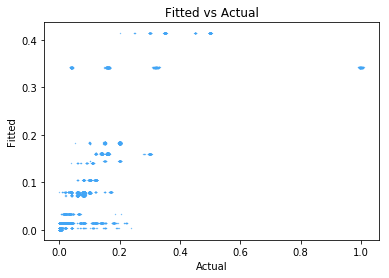

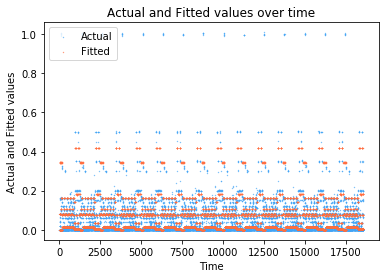

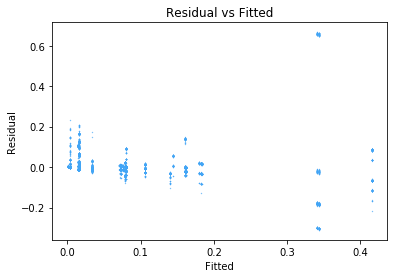

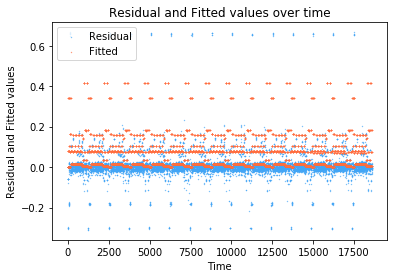

In [111]:
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

<h2>Part ii</h2>

In [ ]:
def plot_func(i, x, oob, rmse, xlabel):
    print("Min OOB error at ",xlabel," : ", x[oob.index(min(oob))], "= ", min(oob))
    print("Min RMSE at ",xlabel," : ", x[rmse.index(min(rmse))], "= ",min(rmse))
    plt.plot(x, oob, label="OOB Error")
    plt.title("Max features: "+str(i))
    plt.legend()
    plt.xlabel(xlabel)
    plt.show()
    plt.title("Max features: "+str(i))
    plt.plot(x, rmse, color='#FB8C00', label='Test RMSE')
    plt.legend()
    plt.xlabel(xlabel)
    plt.show()

Max number of features:  1
Min OOB error at  # Trees  :  195 =  0.512762136272
Min RMSE at  # Trees  :  2 =  0.0698928915494


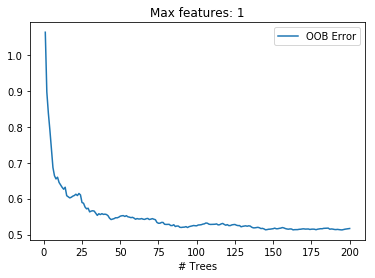

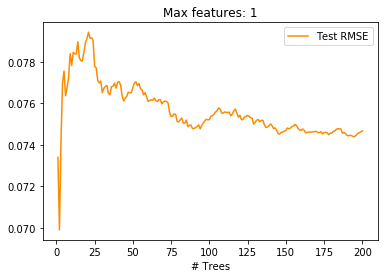

Max number of features:  2
Min OOB error at  # Trees  :  25 =  0.36287171125
Min RMSE at  # Trees  :  2 =  0.0597898399214


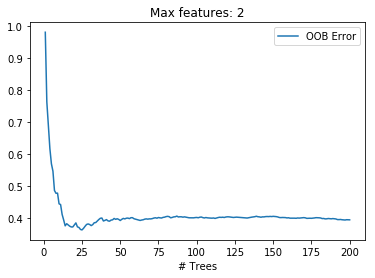

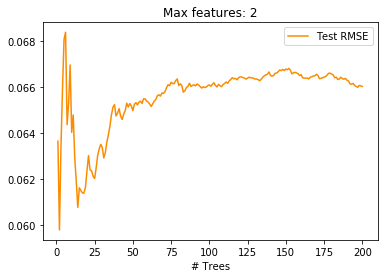

In [ ]:
import warnings
warnings.filterwarnings('ignore')

trees = range(1,201)

for i in range(1,6):
    oob_errors = []
    test_rmse = []
    for t in trees:
        regr = RandomForestRegressor(n_estimators=t, max_depth=4, max_features=i, bootstrap=True, oob_score=True, random_state=0)
        train, test, best_rfr = perform_10fold(X, y, regr)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        #regr.fit(X_train, y_train)
        #y_pred = regr.predict(X_test)
        regr.fit(X,y)
        oob_score = regr.oob_score_
        oob_error = 1 - oob_score
        oob_errors.append(oob_error)
        test_rmse.append(test)
        #test_error = mean_squared_error(y_test,y_pred)
        #test_rmse.append(np.sqrt(test_error))
    print("Max number of features: ",i)
    #plt.plot(trees, test_rmse)
    #plt.show()
    plot_func(i, trees, oob_errors, test_rmse, "# Trees")

<h2>Part iii</h2>

In [ ]:
depths = [1,2,3, 5,7,10,15,20, None]
for i in range(1,6):
    oob_errors = []
    test_rmse = []
    for d in depths:
        regr = RandomForestRegressor(n_estimators=13, max_depth=d, max_features=i, bootstrap=True, oob_score=True, random_state=0)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        #regr.fit(X_train, y_train)
        train, test, best_rfr = perform_10fold(X, y, regr)
        regr.fit(X,y)
        #y_pred = regr.predict(X_test)
        oob_score = regr.oob_score_
        oob_error = 1 - oob_score
        oob_errors.append(oob_error)
        test_rmse.append(test)
        #test_error = mean_squared_error(y_test,y_pred)
        #test_rmse.append(np.sqrt(test_error))
    print("Max number of features: ",i)
    plot_func(i, depths, oob_errors, test_rmse, "Depths")

<h2>Part iv</h2>

In [ ]:
bestModel = RandomForestRegressor(n_estimators=13, max_depth=10, max_features=4, bootstrap=True, oob_score=True, random_state=0)
bestModel.fit(X,y)
print(bestModel.feature_importances_)
print(sorted(zip(map(lambda x: round(x, 4), bestModel.feature_importances_), dataset_copy.columns),
             reverse=True))

In [ ]:
predicted = bestModel.predict(X)

In [ ]:
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

<h2>Part v</h2>

In [ ]:
def plot_bar(importances, indices, features):
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='#42A5F5', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [ ]:
print("Visualizing feature importance for best model in Part iv")
bestModel = RandomForestRegressor(n_estimators=13, max_depth=10, max_features=4, bootstrap=True, oob_score=True, random_state=0)
bestModel.fit(X,y)
features = dataset_copy.columns[0:5]
importances = bestModel.feature_importances_
indices = np.argsort(importances)
plot_bar(importances, indices, features)

In [ ]:
clf = bestModel.estimators_[3]
print("Visualizing feature importance for random forrest estimator with depth restricted to 4")
bestModel = RandomForestRegressor(n_estimators=13, max_depth=4, max_features=4, bootstrap=True, oob_score=True, random_state=0)
bestModel.fit(X,y)
clf = bestModel.estimators_[3]
features = dataset_copy.columns[0:5]
importances = clf.feature_importances_
indices = np.argsort(importances)
plot_bar(importances, indices, features)

In [ ]:
print("Visualizing decision tree for random forrest estimator with depth restricted to 4")
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,   
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 
graph 